##### Project 2 - Big-Scale Analytics 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [4]:
# A disaster tweet
disaster_tweet = train[train['Target'] == 1]['Tweet text']
disaster_tweet.values[1]

'Malaysia Airlines Flight 370 that Disappeared 17months ago Debris Found South of The Indian Ocean - http://t.co/nrHURYSyPd'

In [5]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['Target'] == 0]['Tweet text']
non_disaster_tweet.values[1]

"I've been by the pool all day #raisinfingers"

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Importing libraries

In [1]:
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

# sklearn for classification models
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alixm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# II. EDA

## 1. Training set

### Data loading

In [2]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

(7613, 5)

In [3]:
train.columns = ['ID', 'Keyword', 'Location', 'Tweet text', 'Target']
train.head()

,ID,Keyword,Location,Tweet text,Target
2119,3045,death,Home of the Takers.,Y'all PUSSSSSSSSSY AND SHOOOK TO DEATH OF ME,0
641,930,blaze,NaN,I've been by the pool all day #raisinfingers,0
659,953,blaze,302,Yo I got bars and I'm not even a rapper,0
3560,5088,famine,NaN,A grade in Black Horse Famine[MEGA]. Score 084...,0
5305,7578,outbreak,The Netherlands,Families to sue over Legionnaires: More than 4...,1


### Distribution of the target column

In [6]:
#when the target = 1 it means the the tweet is about a disaster
train_yes = train.query('Target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters (Target = 0).')

#when the target = 0 it means the the tweet is not about a disaster
train_no = train.query('Target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters (Target = 1).')

There are 3271 tweets about disasters (Target = 0).
There are 4342 tweets that are not about disasters (Target = 1).


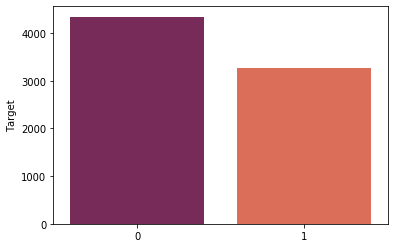

In [7]:
sns.barplot(train['Target'].value_counts().index, train['Target'].value_counts(), palette = 'rocket')

### Distribution of the Keyword column

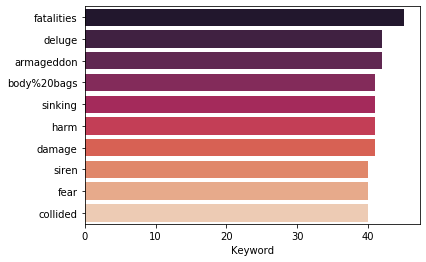

In [8]:
sns.barplot(y = train['Keyword'].value_counts()[:10].index, x = train['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

In [9]:
train.loc[train['Tweet text'].str.contains('disaster', na=False, case=False)].Target.value_counts()

1    102
0     40
Name: Target, dtype: int64

## 2. Test set

### Data loading

In [10]:
test = pd.read_csv('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'keyword', 'location', 'text']]
test.shape

(3263, 4)

In [11]:
test.columns = ['ID', 'Keyword', 'Location', 'Tweet text']
test.head()

,ID,Keyword,Location,Tweet text
2148,7200,natural%20disaster,NaN,@patrickandsam @ghaccount I've been screaming ...
2649,8849,smoke,Roseland,@wizkhalifa smoke ??so much you don't gotta do...
95,323,annihilated,NaN,'If your nature appropriates it love will burn...
1674,5648,flooding,"Maryland, USA",Now WoW folks I'm sorry for all the 'prepared'...
2315,7734,panicking,Bedford,@milefromhome ??.. Don't.. I'm panicking..


### Distribution of the Keyword column

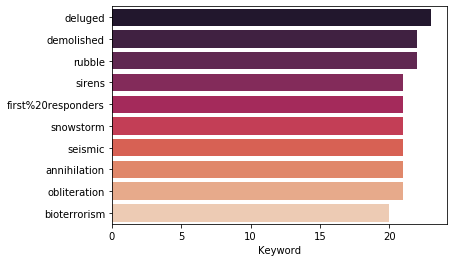

In [12]:
sns.barplot(y = test['Keyword'].value_counts()[:10].index, x = test['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

# III. Data preprocessing and tokenisation

In [13]:
# Applying a first round of text cleaning techniques
#Make text lowercase and remove text in square brackets, links, punctuation, words containing numbers.

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to the dataset
train['Tweet text'] = train['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
train['Tweet text'].head()

2119          yall pusssssssssy and shoook to death of me
641            ive been by the pool all day raisinfingers
659                yo i got bars and im not even a rapper
3560     a grade in black horse famine score \r\rdynamix 
5305    families to sue over legionnaires more than  f...
Name: Tweet text, dtype: object

In [14]:
# Applying the cleaning function to the dataset
test['Tweet text'] = test['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
test['Tweet text'].head()

2148    patrickandsam ghaccount ive been screaming nat...
2649    wizkhalifa smoke so much you dont gotta do shi...
95      if your nature appropriates it love will burn ...
1674    now wow folks im sorry for all the prepared jo...
2315                      milefromhome  dont im panicking
Name: Tweet text, dtype: object

In [15]:
# Tokenising the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['Tweet text'] = train['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
train['Tweet text'].head()

2119    [yall, pusssssssssy, and, shoook, to, death, o...
641     [ive, been, by, the, pool, all, day, raisinfin...
659     [yo, i, got, bars, and, im, not, even, a, rapper]
3560    [a, grade, in, black, horse, famine, score, dy...
5305    [families, to, sue, over, legionnaires, more, ...
Name: Tweet text, dtype: object

In [16]:
test['Tweet text'] = test['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
test['Tweet text'].head()

2148    [patrickandsam, ghaccount, ive, been, screamin...
2649    [wizkhalifa, smoke, so, much, you, dont, gotta...
95      [if, your, nature, appropriates, it, love, wil...
1674    [now, wow, folks, im, sorry, for, all, the, pr...
2315                  [milefromhome, dont, im, panicking]
Name: Tweet text, dtype: object

In [17]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['Tweet text'] = train['Tweet text'].apply(lambda x : remove_stopwords(x))
train['Tweet text'].head()

2119                  [yall, pusssssssssy, shoook, death]
641                       [ive, pool, day, raisinfingers]
659                     [yo, got, bars, im, even, rapper]
3560        [grade, black, horse, famine, score, dynamix]
5305    [families, sue, legionnaires, families, affect...
Name: Tweet text, dtype: object

In [18]:
test['Tweet text'] = test['Tweet text'].apply(lambda x : remove_stopwords(x))
test['Tweet text'].head()

2148    [patrickandsam, ghaccount, ive, screaming, nat...
2649    [wizkhalifa, smoke, much, dont, gotta, shit, l...
95      [nature, appropriates, love, burn, become, ann...
1674    [wow, folks, im, sorry, prepared, jokes, must,...
2315                  [milefromhome, dont, im, panicking]
Name: Tweet text, dtype: object

# IV. Classification models


## 1. KNN classifier
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification (and also regression). In k-NN classification, The input consists of the k closest training examples in the feature space. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [35]:
from sklearn.model_selection import train_test_split

X = train['Tweet text']
ylabels = train['Target']


print('X shape: ', X.shape)
print('y shape: ', ylabels.shape)

X.head()

X shape:  (7613,)
y shape:  (7613,)


2119                  [yall, pusssssssssy, shoook, death]
641                       [ive, pool, day, raisinfingers]
659                     [yo, got, bars, im, even, rapper]
3560        [grade, black, horse, famine, score, dynamix]
5305    [families, sue, legionnaires, families, affect...
Name: Tweet text, dtype: object

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training set
word_vectorizer = CountVectorizer()
X_train = word_vectorizer.fit_transform(train['Tweet text'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(test['Tweet text'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is diaster tweet
y_train = train['Target']

X_train.shape

(7613, 16222)

In [57]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

0.7877315170943323


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [58]:
BNB = BernoulliNB()
scores = cross_val_score(BNB, X_train, y_train)
print(scores.mean())

0.7978446237382939


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [59]:
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
scores = cross_val_score(knn, X_train, y_train)
print(scores.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7078655615933677


In [60]:
y_test = train['Tweet text']
preds = clf.predict(y_test)

sub_train['Target'] = preds
sub_df.to_csv("submission.csv",index=False)

ValueError: setting an array element with a sequence.